In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# specify the paths to the directories containing the images
non_COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\non-COVID'
COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\COVID'

In [3]:
# Set the batch size and epochs for training
batch_size = 16
epochs = 10

In [4]:
# Set the number of uncertain instances to select in each active learning iteration
n_uncertain = 5

In [5]:
# Initialize lists to store the images and labels
images = []
labels = []

In [6]:
# Load the images and labels from the non-COVID and COVID directories
for image_dir, label in [(non_COVID, 0), (COVID, 1)]:
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img = Image.open(os.path.join(image_dir, filename))
        img = img.convert('RGB')
        img = img.resize((64, 64))
        img = np.array(img)
        images.append(img)
        labels.append(label)

In [7]:
# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Create the train, validation, and test datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(buffer_size=len(X_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [10]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')
print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')
print(len(y_train)+len(y_val)+len(y_test))

Number of samples in each set (train, val, test): (1587, 397, 497)
Number of positive samples in each set: (797, 196, 259)
2481


In [11]:
# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))

# Add an output layer with a single node and sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
def select_uncertain(model, images, labels):
    # Get the model's predictions for the images
    predictions = model.predict(images)
    
    # Initialize lists to store the selected images and labels
    selected_images = []
    selected_labels = []
    
    # Iterate over the images and labels
    for image, label, prediction in zip(images, labels, predictions):
        # Calculate the absolute difference between the prediction and the label
        difference = abs(prediction - label)
        
        # If the difference is greater than a certain threshold, add the image and label to the selected lists
        if difference > 0.5:
            selected_images.append(image)
            selected_labels.append(label)
    
    # Return the selected images and labels
    return selected_images, selected_labels

In [170]:
# Loop until there are no more uncertain instances
while True:
    # Select a batch of uncertain instances
    uncertain_images, uncertain_labels = select_uncertain(model, images, labels)
    
    # Break the loop if there are no more uncertain instances
    if len(uncertain_images) == 0:
        break
    
    # Take the first n_uncertain instances
    uncertain_images = uncertain_images[:n_uncertain]
    uncertain_labels = uncertain_labels[:n_uncertain]
    
    # Add the uncertain instances to the training dataset
    train_ds = train_ds.concatenate(tf.data.Dataset.from_tensor_slices((uncertain_images, uncertain_labels)).batch(batch_size))
    
    # Shuffle the training dataset
    train_ds = train_ds.shuffle(buffer_size=len(X_train))
    
    # Train the model on the updated training dataset
    history = model.fit(train_ds, epochs=2, validation_data=val_ds)
    
    # Get the training and validation accuracy and loss for each epoch
    accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    losses = history.history['loss']
    val_losses = history.history['val_loss']

    # Initialize a figure with 2 subplots
    #fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and validation accuracy curves on the first subplot
    #ax[0].plot(accuracies)
    #ax[0].plot(val_accuracies)
    #ax[0].set_title('Model accuracy')
    #ax[0].set_ylabel('Accuracy')
    #ax[0].set_xlabel('Epoch')
    #ax[0].legend(['Training', 'Validation'], loc='upper left')

    # Plot the training and validation loss curves on the second subplot
    #ax[1].plot(losses)
    #ax[1].plot(val_losses)
    #ax[1].set_title('Model loss')
    #ax[1].set_ylabel('Loss')
    #ax[1].set_xlabel('Epoch')
    #ax[1].legend(['Training', 'Validation'], loc='upper left')

    #plt.show()

78/78 [==============================] - 2s 27ms/step


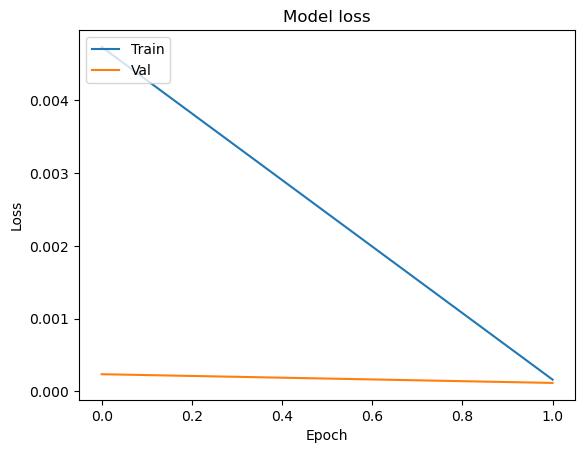

In [168]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [166]:
# Evaluate the model on the val dataset
loss, accuracy = model.evaluate(val_ds)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

25/25 [==============================] - 1s 21ms/step - loss: 1.1423e-04 - accuracy: 1.0000
Test loss: 0.0001
Test accuracy: 1.0000


In [171]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

32/32 [==============================] - 1s 24ms/step - loss: 1.6579e-04 - accuracy: 1.0000
Test loss: 0.0002
Test accuracy: 1.0000


In [165]:
##### Load the image
image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\My Evaluation\7 - normal.jpg'
image = Image.open(image_path)

# Preprocess the image
image = image.convert('RGB')
image = image.resize((64, 64))
image = np.array(image)

# Reshape the image to match the model's input shape
image = image.reshape(1, 64, 64, 3)

# Get the model's prediction
prediction = model.predict(image)[0]

# Print the prediction
if prediction > 0.5:
    print('COVID')
else:
    print('non-COVID')

# Print the probability of the prediction
print(prediction)

1/1 [==============================] - 0s 57ms/step
COVID
[1.]
